# CLTV Prediction With BG-NBD ve Gamma-Gamma 


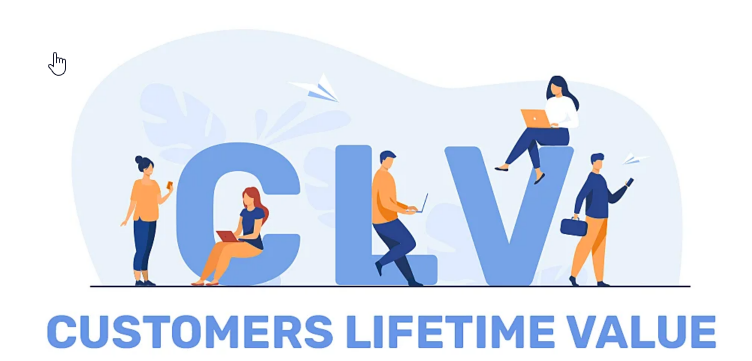


Customer lifetime value (CLTV) is considered as the monetary value that a customer will bring to a company during the relationship and communication he establishes with a company. If a company determines the future benefits it can provide to its customers, it can streamline customer relations and take a more value-added approach. One of the biggest problems of many national and international companies is calculating customer lifetime value.

CLTV also plays an important role in determining marketing budgets. A company that has calculated unit costs within the scope of acquiring new customers can make a comparison between marketing activities for its existing customer base and efforts to find new customers with customer lifetime value calculations.

**BG/NBD Model (Beta Geometric / Negative Binomial Distribution)**
Beta geometric distribution and negative binomial distribution are discrete probability distributions studied in the branches of statistics and probability sciences.In addition, the BG/NBD model is a probabilistic model that is also used as a stand-alone sales forecasting model. BG/NBD probabilistically models two processes for the expected number of transactions:
Purchasing process: Transaction rates vary for each customer and are gamma distributed for the entire audience.
Dropout process (Churn): Dropout rate varies for each customer and beta is distributed for the entire audience.

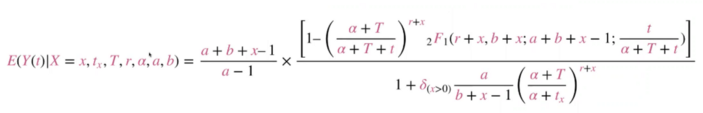

The meanings of the variables used in this formula:

x: Frequency, the number of recurring sales for users who have traded at least twice.
t_x: Recency is the time since the customer's first and last purchase. Depending on the approach, it is generally calculated annually, monthly and weekly.
T (Tenure): The time between the first time the customer interacts with the company and the time we set the reference. It represents the age of the customer.
r, α: Comes from the Gamma distribution. Models the transaction rate.
b, a: Models the dropout rate and comes from the beta distribution.

**Gamma-Gamma Model**

It is used to estimate how much profit a customer can bring per transaction on average, and the monetary value of the customer's transactions is randomly distributed around the average of the transaction values. The average transaction value is gamma distributed among all customers.

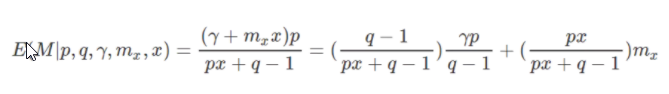

p, q, γ: Transaction values models and come from the gamma distribution,
m_x: Monetary refers to the average earnings per purchase,
x: Frequency is the number of recurring sales for users who have traded at least twice.

**As a result, by multiplying the BG/ NPV and Gamma-Gamma models, creating a time-projected prediction model, CLTV prediction can be achieved across all customers.**

**Dataset Story**

The dataset consists of the information obtained from the past shopping behavior of customers who made their last purchases from Flo as OmniChannel (both online and offline shopper) between 2020 and 2021.

master_id : Unique customer number

order_channel: Which channel of the shopping platform is used (Android, ios, Desktop, Mobile)

last_order_channel: The channel where the most recent purchase was made

first_order_date: Date of the customer's first purchase

last_order_date: Customer's last purchase date

last_order_date_online: The date of the last purchase made by the customer on the online platform

last_order_date_offline:The date of the last purchase made by the customer on the offline platform

order_num_total_ever_online: The total number of purchases made by the customer on the online platform

order_num_total_ever_offline: Total number of purchases made by the customer offline

customer_value_total_ever_offline: Total fee paid by the customer for offline purchases

customer_value_total_ever_online: The total fee paid by the customer for their online shopping

interested_in_categories_12: List of categories the customer has shopped in the last 12 months

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter  #!pip install lifetimes
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', lambda x: '%.3f' % x) # ondalık gösterimi
df_ = pd.read_csv("flo_data_20k.csv", sep=',')
df = df_.copy()


In [16]:
def check_df(dataframe, head=5):
    print(" SHAPE ".center(90, '~'))
    print("%d rows and %d columns" % dataframe.shape)
    print(" SIZE ".center(90, '~'))
    print(dataframe.size)
    print(" TYPES ".center(90, '~'))
    print(dataframe.dtypes)
    print(" HEAD ".center(90, '~'))
    print(dataframe.head(head))
    print(" TAIL ".center(90, '~'))
    print(dataframe.tail(head))
    print(" NA ".center(90, '~'))
    print(dataframe.isna().sum())
    print(" DP ".center(90, '~'))
    print(dataframe.duplicated().sum())
    print(" CATSUM ".center(90, '~'))
    print(dataframe.describe(include="O"))
    print(" DESC ".center(90, '~'))
    quantiles = dataframe.describe([0.05, 0.10, 0.25, 0.5, 0.75, 0.9, 0.95,0.99]).T
    quantiles['IQR'] = quantiles['75%'] - quantiles['25%']
    print(quantiles)

check_df(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SHAPE ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
19945 rows and 12 columns
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SIZE ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
239340
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ TYPES ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ HEAD ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                              master_id order_cha

**Outliers**

Outliers are data points that are far from other data points. In other words, they're unusual values in a dataset. Outliers are problematic for many statistical analyses because they can cause tests to either miss significant findings or distort real results.

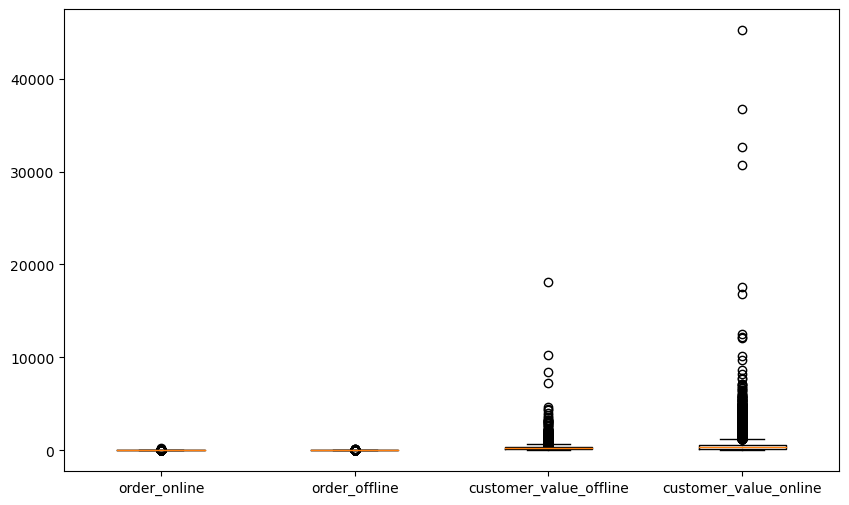

In [15]:
plt.figure(figsize=(10, 6))
plt.boxplot([df['order_num_total_ever_online'], df['order_num_total_ever_offline'], df['customer_value_total_ever_offline'], df['customer_value_total_ever_online']])

plt.xticks([1, 2, 3, 4], ['order_online', 'order_offline', 'customer_value_offline', 'customer_value_online'])
plt.show()

In [18]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01) 
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit 

replace_with_thresholds(df, "order_num_total_ever_online")
replace_with_thresholds(df, "order_num_total_ever_offline")
replace_with_thresholds(df, "customer_value_total_ever_offline")
replace_with_thresholds(df, "customer_value_total_ever_online")

                                      count    mean     std    min     5%     25%     50%      90%      95%      99%      max
order_num_total_ever_online       19945.000   3.092   3.814  1.000  1.000   1.000   2.000    7.000   10.000   20.000   48.500
order_num_total_ever_offline      19945.000   1.886   1.435  1.000  1.000   1.000   1.000    4.000    4.000    7.000   16.000
customer_value_total_ever_offline 19945.000 251.921 251.023 10.000 39.990  99.990 179.980  519.950  694.222 1219.947 3019.882
customer_value_total_ever_online  19945.000 489.705 632.606 12.990 63.990 149.980 286.460 1082.036 1556.726 3143.810 7799.541


In [32]:
df["total_order_num"]=df["order_num_total_ever_online"]+df["order_num_total_ever_offline"]
df["total_customer_value"]=df["customer_value_total_ever_offline"]+df["customer_value_total_ever_online"]

for col in df.columns:
    if "date" in col:
        df[col] = pd.to_datetime(df[col])

**Creating the CLTV Data Structure**

1- 2 days after the date of the last purchase in the data set will be taken as the analysis date.

2- A new cltv dataframe will be created containing customer_id, recency_cltv_weekly, T_weekly, frequency and monetary_cltv_avg values.

3-Monetary value will be expressed as the average value per purchase, and recency and tenure values will be expressed in weekly basis.

In [34]:
today_date = df["last_order_date"].max() + pd.DateOffset(days=2)

 **Recency**: Time since last purchase. Weekly. (user specific) (last - first)
 
 **T**: Age of the customer. Weekly. (how long before the date of analysis was the first purchase made)
 
 **Frequency**: total number of recurring purchases (frequency>1)
 
 **Monetary**: average earnings per purchase

In [35]:
cltv_df = pd.DataFrame(df["master_id"])
cltv_df["recency_cltv_weekly"]= (((df["last_order_date"]-df["first_order_date"]))/7).dt.days
cltv_df["T_weekly"] = (((today_date-df["first_order_date"]))/7).dt.days
cltv_df["frequency"] = df["total_order_num"]
cltv_df["monetary_cltv_avg"] = df["total_customer_value"] / df["total_order_num"]
cltv_df= cltv_df[cltv_df["frequency"] > 1]

cltv_df.columns = ['master_id','recency', 'T', 'frequency', 'monetary']

In [37]:
cltv_df.head()

,master_id,recency,T,frequency,monetary
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17,30,5.000,187.874
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209,224,21.000,95.883
2,69b69676-1a40-11ea-941b-000d3a38a36f,52,78,5.000,117.064
3,1854e56c-491f-11eb-806e-000d3a38a36f,1,20,2.000,60.985
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83,95,2.000,104.990


# BG/NBD, Establishment of Gamma-Gamma Models, Calculation of CLTV

In [46]:
bgf = BetaGeoFitter(penalizer_coef=0.001) # ceza kat sayısı

bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

C:\Users\oktay\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 75.49, b: 0.00, r: 3.65>

**Forecast of expected purchases from customers within 3 months**

In [47]:
cltv_df["exp_sales_3_month"] = bgf.predict(12,
                                       cltv_df['frequency'],
                                       cltv_df['recency'],
                                       cltv_df['T'])

**Forecast of expected purchases from customers within 6 months**

In [48]:
cltv_df["exp_sales_6_month"] = bgf.predict(24,
                                       cltv_df['frequency'],
                                       cltv_df['recency'],
                                       cltv_df['T'])

In [49]:
cltv_df.sort_values(by = "exp_sales_6_month", ascending =False).head()

,master_id,recency,T,frequency,monetary,exp_sales_3_month,exp_sales_6_month
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62,67,52.500,164.633,4.729,9.457
15611,4a7e875e-e6ce-11ea-8f44-000d3a38a36f,39,40,29.000,165.298,3.392,6.785
8328,1902bf80-0035-11eb-8341-000d3a38a36f,28,33,25.000,97.440,3.169,6.338
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52,58,31.000,228.530,3.115,6.229
14373,f00ad516-c4f4-11ea-98f7-000d3a38a36f,38,46,27.000,141.355,3.027,6.055


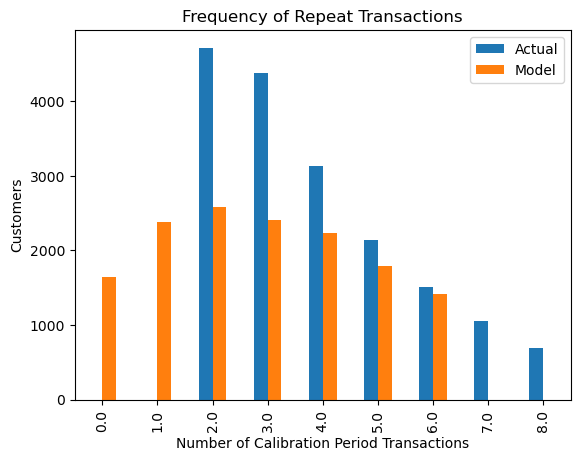

In [54]:
plot_period_transactions(bgf)  # success is measured. The closer 2 colors are, the better the success.
plt.show()


**Fit the Gamma-Gamma model. The process of estimating the average value that customers will give.**

In [55]:
cltv_df["frequency"] = cltv_df["frequency"].astype(int)

ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df['frequency'],
        cltv_df['monetary'])

cltv_df["exp_average_value"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                       cltv_df['monetary'])
cltv_df.head()

,master_id,recency,T,frequency,monetary,exp_sales_3_month,exp_sales_6_month,exp_average_value
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17,30,5,187.874,0.984,1.968,193.633
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209,224,21,95.883,0.988,1.975,96.665
2,69b69676-1a40-11ea-941b-000d3a38a36f,52,78,5,117.064,0.676,1.352,120.968
3,1854e56c-491f-11eb-806e-000d3a38a36f,1,20,2,60.985,0.710,1.420,67.320
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83,95,2,104.990,0.398,0.795,114.325


**Calculate 6 months CLTV**

In [57]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=6,  # 3 ay
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)
cltv=cltv.to_frame()
cltv_df["cltv"] = cltv["clv"]
cltv_df.sort_values("cltv",ascending=False)[:20]

,master_id,recency,T,frequency,monetary,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2,7,4,1401.771,1.113,2.225,1449.030,3383.545
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6,13,11,758.044,1.987,3.973,767.318,3198.664
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51,101,7,1106.467,0.724,1.448,1127.611,1713.325
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74,74,16,501.845,1.577,3.155,506.138,1675.245
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3,34,8,601.226,1.277,2.553,611.493,1638.291
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62,67,52,164.633,4.729,9.457,165.116,1623.819
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8,9,2,862.690,0.802,1.605,923.680,1555.209
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9,13,17,259.865,2.800,5.600,262.073,1539.934
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52,58,31,228.530,3.115,6.229,229.607,1500.731
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14,15,3,743.587,0.882,1.764,778.050,1439.660


**Creating Segments Based on CLTV**

In [58]:
cltv_df["cltv_segment"] = pd.qcut(cltv_df["cltv"], 4, labels=["D", "C", "B", "A"])
cltv_df.groupby("cltv_segment").agg(
    {"count", "mean", "sum"})

recency                     T                 frequency              monetary                     exp_sales_3_month                exp_sales_6_month                exp_average_value                      cltv                    
               count    mean     sum count    mean     sum     count  mean    sum    count    mean         sum             count  mean      sum             count  mean      sum             count    mean         sum count    mean         sum
cltv_segment                                                                                                                                                                                                                                    
D               4987 138.712  691757  4987 161.915  807468      4987 3.770  18801     4987  93.232  464947.494              4987 0.410 2045.060              4987 0.820 4090.119              4987  98.774  492584.687  4987  80.624  402069.784
C               4986  92.231  459864  4986 112.465  560750      4986 4.407  21971     4986 125.864  627555.959              4986 0.528 2631.186              4986 1.055 5262.372              4986 132.327  659783.836  4986 138.933  692721.526
B               4986  81.507  406393  4986  99.787  497536      4986 5.098  25418     4986 160.479  800148.453              4986 0.605 3016.072              4986 1.210 6032.144              4986 167.828  836792.398  4986 200.539  999889.272
A               4986  66.891  333517  4986  82.015  408929      4986 6.638  33099     4986 228.829 1140943.792              4986 0.778 3877.913              4986 1.556 7755.826              4986 238.033 1186831.998  4986 364.557 1817679.852